In [16]:
from typing import Dict, List, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore, ttest_ind
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from plotnine import (
    aes,
    element_text,
    geom_boxplot,
    ggplot,
    labs,
    scale_fill_gradient2,
    scale_y_continuous,
    scale_x_continuous,
    scale_color_discrete,
    scale_fill_discrete,
    theme,
    theme_bw,
    geom_density,
    geom_tile,
    facet_wrap,
    coord_fixed,
    theme_minimal,
    coord_cartesian,
)

In [17]:
# for debugging visit: https://docs.kedro.org/en/stable/notebooks_and_ipython/kedro_and_notebooks.html#debugging-a-kedro-project-within-a-notebook
# choose kernel Kedro (pimapy)
df = catalog.load("pima_imputed")
df.head(5)

[06/03/25 06:21:42] INFO     Loading data from pima_imputed (CSVDataset)...                     ]8;id=688832;file:///Users/rkw/miniconda3/envs/kedro312/lib/python3.12/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=419758;file:///Users/rkw/miniconda3/envs/kedro312/lib/python3.12/site-packages/kedro/io/data_catalog.py#403\403]8;;\

,pregnant,glucose,blood_pr,skin_thi,insulin,bmi,dbts_pdgr,age,flag_imp,outcome
0,6.0,148.0,72.0,35.000000,127.477659,33.6,0.627000,50.0,True,1.0
1,1.0,85.0,66.0,29.000000,120.094622,26.6,0.351000,31.0,True,0.0
2,8.0,183.0,64.0,16.168751,298.445158,23.3,0.672000,32.0,True,1.0
3,1.0,89.0,66.0,23.000000,94.000000,28.1,0.167000,21.0,False,0.0
4,0.0,137.0,40.0,35.000000,168.000000,43.1,0.739128,33.0,True,1.0


In [20]:
 def plot_zscore_boxplots(
    df: pd.DataFrame,
    outcome_col: str = "outcome",
    title: Optional[str] = "Boxplots of Features (Z-scored)",
    highlight_outliers: bool = True,
    outlier_color: str = ""
) -> "ggplot":
    """
    Z-score all columns except `outcome_col` (and any metadata columns like "flag_imp"),
    then plot boxplots with y-limits [-6,6]. If highlight_outliers is True, color outliers
    in `outlier_color`.

    This version explicitly converts feature columns to numeric, drops entirely-NaN or
    zero-variance features, and raises if there is no data to plot.
    """
    # 1) Decide which columns to treat as “features”:
    #    - Exclude outcome_col
    #    - Exclude any metadata columns (e.g. “flag_imp”)
    features = [
        c
        for c in df.columns
        if c not in {outcome_col, "flag_imp"}
    ]

    # 2) Make a local copy so we don’t modify the original DataFrame
    df_numeric = df.copy()

    # 3) Explicitly coerce each feature column to numeric (strings → NaN if they fail)
    for col in features:
        df_numeric[col] = pd.to_numeric(df_numeric[col], errors="coerce")

    # 4) Drop any feature column that is entirely NaN or has zero variance
    numeric_features: List[str] = []
    for col in features:
        col_data = df_numeric[col]
        if col_data.isna().all():
            # skip columns with no numeric data
            continue
        if col_data.std(skipna=True) == 0:
            # skip columns with zero variance
            continue
        numeric_features.append(col)

    if not numeric_features:
        raise ValueError(
            f"No valid numeric features left after dropping outcome and metadata. "
            f"Checked columns (excluding '{outcome_col}' and 'flag_imp'): {features}"
        )

    # 5) Compute Z-scores on the remaining numeric features
    df_z = df_numeric[numeric_features].apply(zscore, nan_policy="omit")

    # 6) Melt into long‐form for Plotnine
    df_melted = df_z.melt(var_name="Feature", value_name="Z_score")

    # 7) If there are no finite Z-scores, we cannot draw a boxplot
    if df_melted["Z_score"].dropna().empty:
        raise ValueError(
            "After computing z‐scores, no finite (non‐NaN) values remain. Cannot draw boxplots."
        )

    # 8) Choose the boxplot layer (with or without colored outliers)
    if highlight_outliers:
        box_layer = geom_boxplot(na_rm=True, outlier_color=outlier_color, notch=True, notchwidth = .25)
    else:
        box_layer = geom_boxplot(na_rm=True, notch=True, notchwidth = .25)

    # 9) Assemble the final plot
    p = (
        ggplot(df_melted, aes(x="Feature", y="Z_score"))
        + box_layer
        + theme_bw()
        + labs(title=title, y="Z-score", x="")
        + theme(axis_text_x=element_text(rotation=45, hjust=1))
        + scale_y_continuous(limits=(-6, 6))
    )
    return(p)

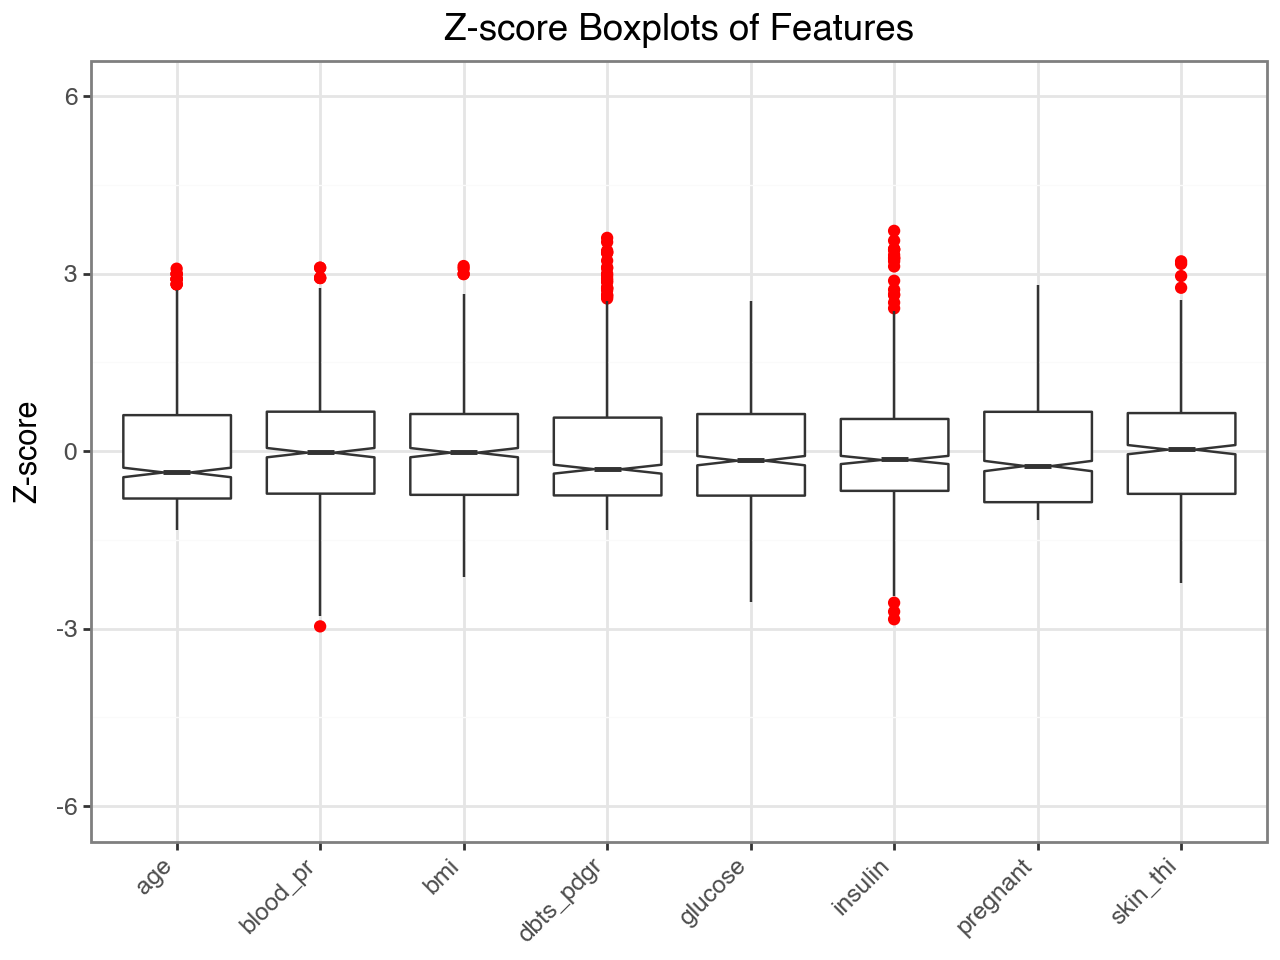

In [21]:
p = plot_zscore_boxplots(
    df=df,
    outcome_col="outcome",
    title="Z-score Boxplots of Features",
    highlight_outliers=True,
    outlier_color="red"
)
p